# ECG Classification

In [1]:
import os
import pandas as pd
import numpy as np
import wfdb
import ast

import random

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

from sklearn.model_selection import train_test_split

import scripts.plots_aux as pa
import scripts.load_data_aux as ld
import scripts.manipulate_data_aux as md
import scripts.utils_ecg as ue

%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
imgs_path = "imgs/"
random_state = 203129
n_sample = 5
urgency_colors = {1: '#EC0D0D', 2:'#EC7D0D', 3:'#E9EC0D', 4:'#0DEC84'}

## Load labels

In [3]:
labels = ld.load_labels('data/')
labels.head()

,Diagnostic Description,Abbreviation,Urgency,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes,Kind
SNOMED CT Code,,,,,,,,,,,,
270492004,1st degree av block,IAVB,4,722,106,0,0,797,769,2394,NaN,most
164889003,atrial fibrillation,AF,4,1221,153,2,15,1514,570,3475,NaN,most
164890007,atrial flutter,AFL,4,0,54,0,1,73,186,314,NaN,most
426627000,bradycardia,Brady,4,0,271,11,0,0,6,288,NaN,most
713427006,complete right bundle branch block,CRBBB,3,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...,most


## Initial exploration

We first visualize the data we are working with.

In [4]:
current_db = 'PTB-XL'
path = f'data/{current_db}/'
files = os.listdir(path)
hea_files = [file[:-4] for file in files if 'hea' in file]

Let's plot some of these.

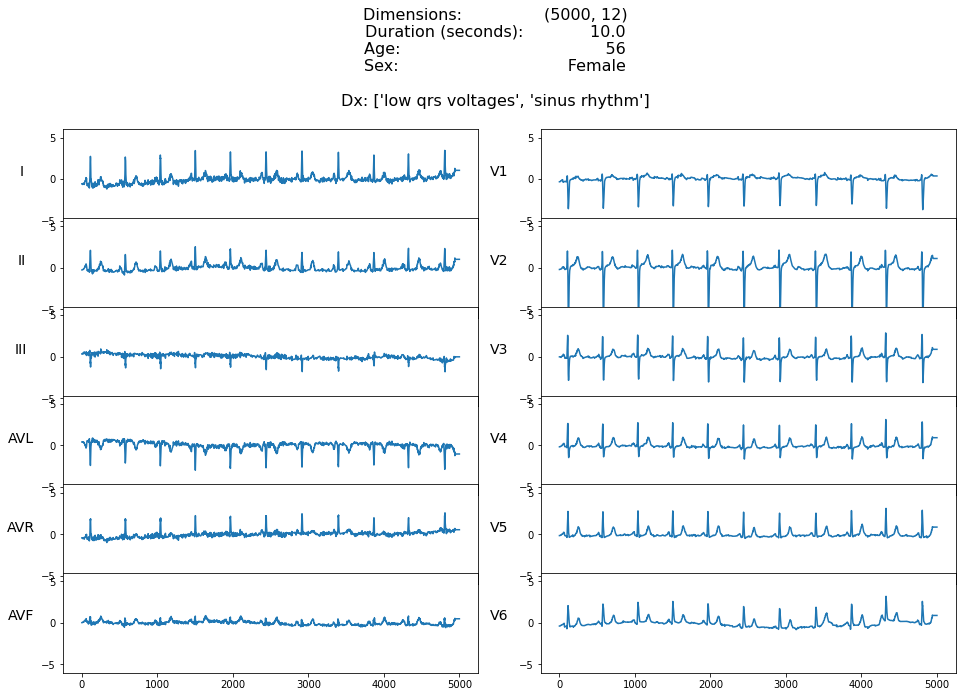

In [8]:
k = 0
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], metadata=metadata)

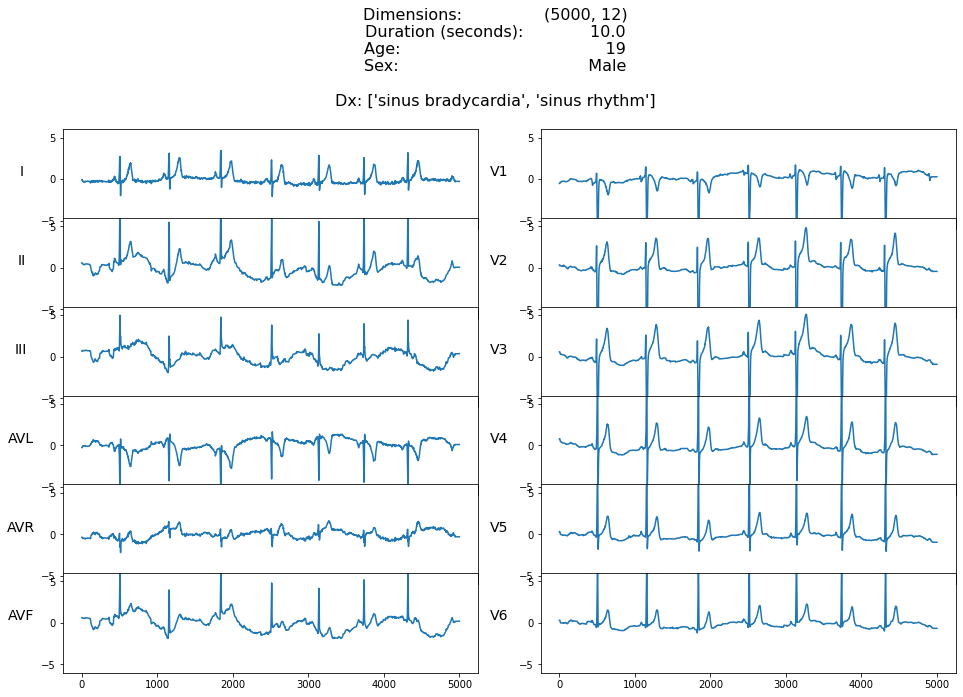

In [9]:
k = 1
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], metadata=metadata)

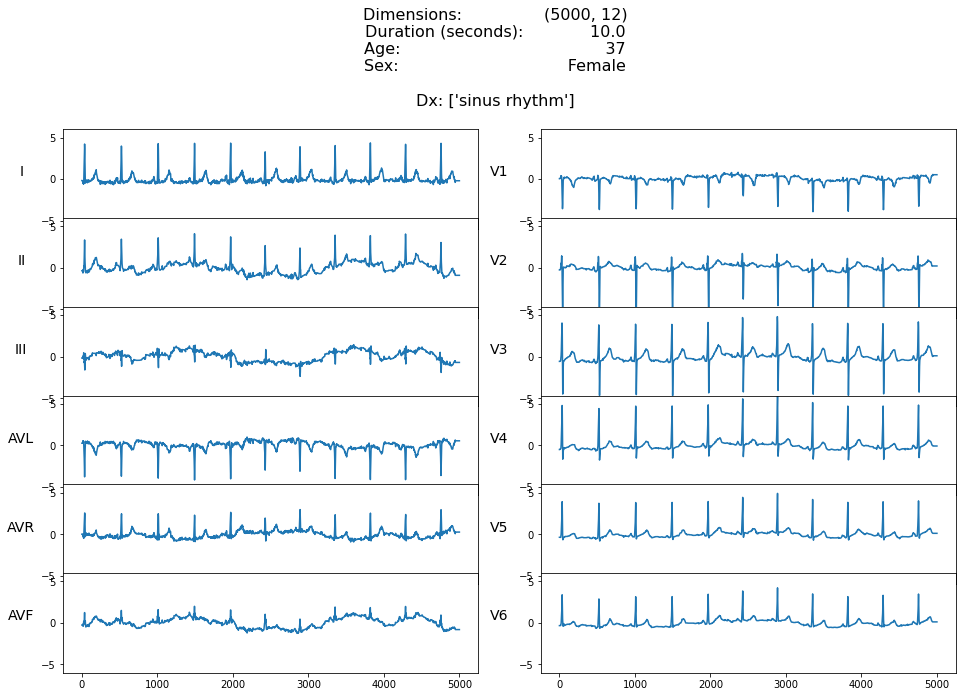

In [10]:
k = 2
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], metadata=metadata)

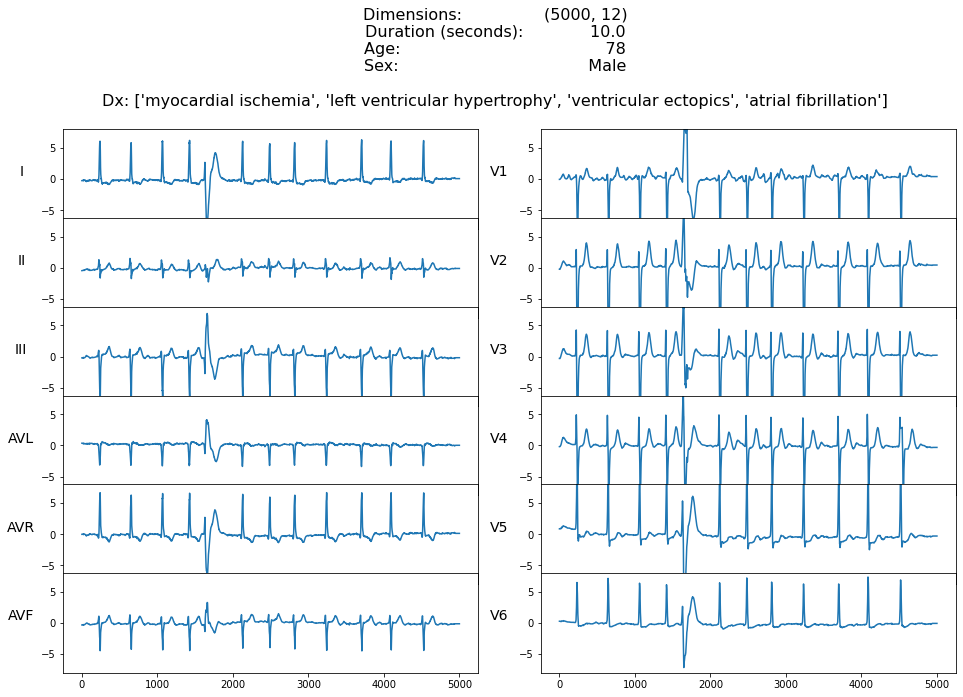

In [11]:
k = 451
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], ylim=(-8,8), metadata=metadata)

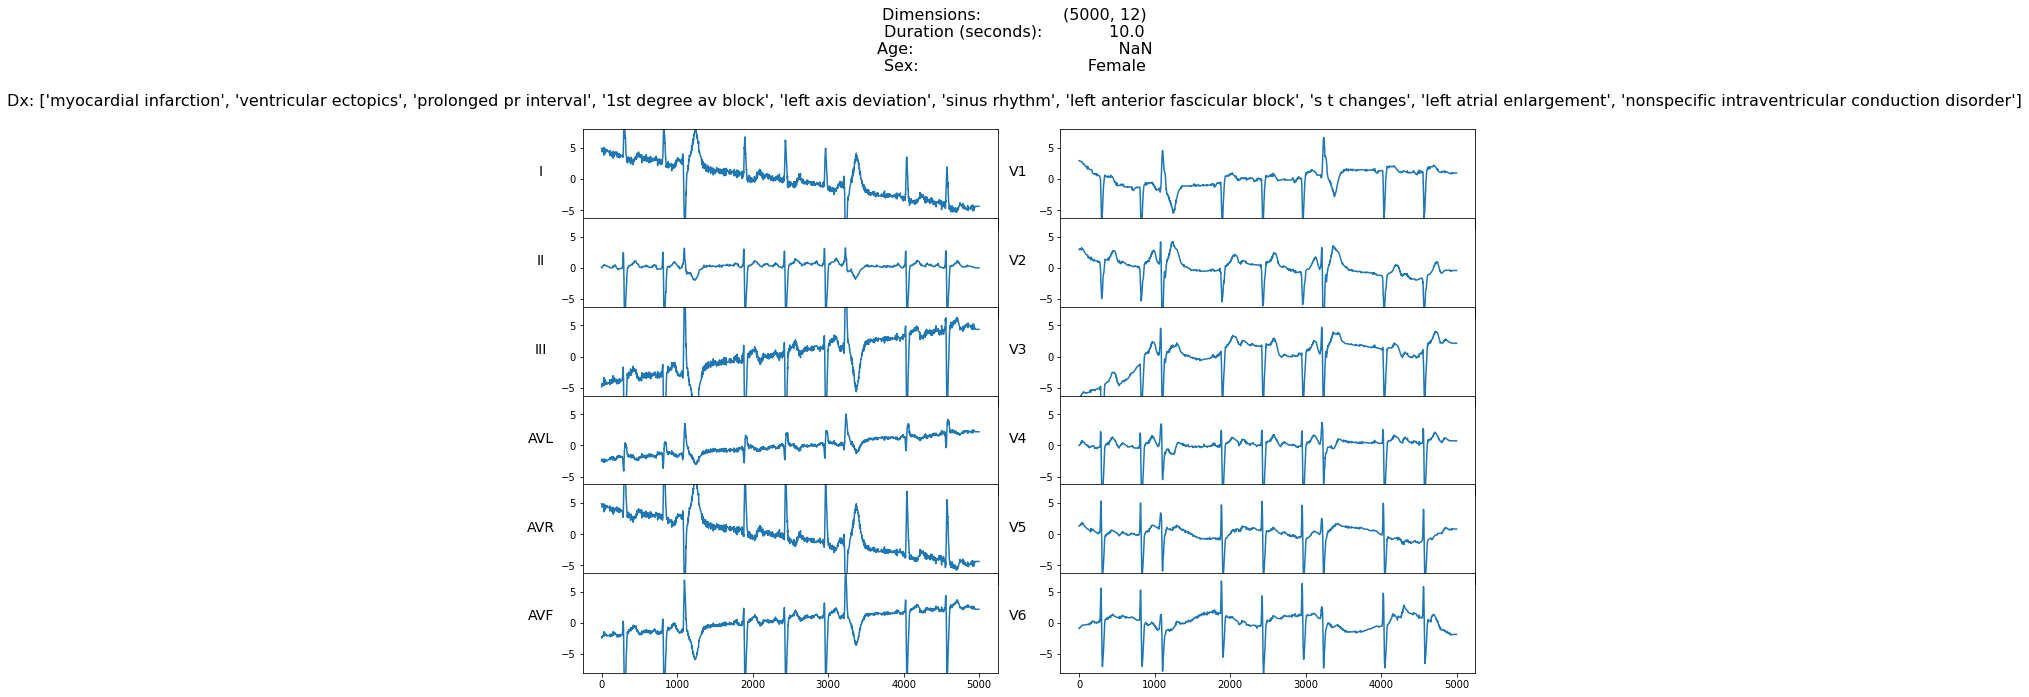

In [12]:
# We put this example just to remember that we still need to make some upgrades to the visualization
k = 1188
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], ylim=(-8,8), metadata=metadata)

### Get all data

Retrieve the signal and the metadata for each file. This takes a like 2-3 minutes for the PTB-XL db.

In [13]:
# Initialize empty lists
X = []
Y = []

# Given the wfdb.rdsamp tuple, pass its values to X and Y, respectively
for file in hea_files:
    f = wfdb.rdsamp(path+file)
    X.append(f[0])
    Y.append(f[1])

Preprocess these to make them more easily usable. This takes like 4 minutes for the PTB-XL db.

In [14]:
X, Y = md.initial_data_preproc(X, Y)

Get some insight of what we just retrieved.

In [15]:
print(X.shape)
print(Y.shape)

(21837, 5000, 12)
(21837, 11)


In [16]:
print("An example of signals in raw format:\n", X[0])
print("\nMinimum value of signals:", X.min())
print("\nMaximum value of signals:", X.max())

An example of signals in raw format:
 [[-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 ...
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]]

Minimum value of signals: -163.46

Maximum value of signals: 163.58


In [17]:
Y.head()

,age,sex,dx,rx,hx,sx,fs,sig_len,n_sig,units,sig_name
0,56,Female,"251146004,426783006",Unknown,Unknown,Unknown,500,5000,12,"[mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]","[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5..."
1,19,Male,"426177001,426783006",Unknown,Unknown,Unknown,500,5000,12,"[mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]","[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5..."
2,37,Female,426783006,Unknown,Unknown,Unknown,500,5000,12,"[mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]","[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5..."
3,24,Male,426783006,Unknown,Unknown,Unknown,500,5000,12,"[mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]","[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5..."
4,19,Female,426783006,Unknown,Unknown,Unknown,500,5000,12,"[mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]","[I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5..."


We can see that only age, sex and dx change amongst the columns of Y, so we can omit them. However, this is the case for the PTB-XL db. It might be the case that other dbs have different values for these, so we will keep that in mind moving along the way.

In [18]:
print("# of unique values of Rx:", Y['rx'].nunique())
print("# of unique values of Hx:", Y['hx'].nunique())
print("# of unique values of Sx:", Y['sx'].nunique())
print("# of unique values of fs:", Y['fs'].nunique())
print("# of unique values of sig_len:", Y['sig_len'].nunique())
print("# of unique values of n_sig:", Y['n_sig'].nunique())
print("# of unique values of units:", Y['units'].astype(str).nunique())
print("# of unique values of sig_name:", Y['sig_name'].astype(str).nunique())

# of unique values of Rx: 1
# of unique values of Hx: 1
# of unique values of Sx: 1
# of unique values of fs: 1
# of unique values of sig_len: 1
# of unique values of n_sig: 1
# of unique values of units: 1
# of unique values of sig_name: 1


### Labelling for each Diagnosis

This one takes quite a long time, possibly around 10 minutes.

In [19]:
# Y_label = md.y_labelling(Y['dx'], labels.index)

For that reason, we better save all of it into one csv file for later use.

In [20]:
# Y_df = pd.concat([Y, Y_label], 1)
# Y_df.to_csv(path + 'Y.csv')

We read it now to avoid possible future type mismatches

In [21]:
Y_df = pd.read_csv(path + 'Y.csv', index_col=0)
Y_df.columns = list(Y_df.columns[:11]) + list(Y_df.columns[11:].astype(np.int64))

#### Note: We are setting NaN values in age as 0. This is not necessarily correct, but it is a way to move forward. It's important to keep this in mind since we might later on chose something else, like setting an overall mean or a grouped by dx mean.

In [22]:
Y_df['age'] = Y_df['age'].fillna(0)
Y_df['age'] = Y_df['age'].apply(lambda x: int(x))

### Verification of diagnosis

Dr. Araiza asked of us to plot several examples of some diagnosis to check if they are indeed what we will eventually try to predict.

We define these requirements given the way we defined the plotting function. They are basically path or variable pointers.

In [23]:
requirements = {'path' : path, 'hea_files' : hea_files, 'imgs_path' : imgs_path,
                'current_db' : current_db, 'labels' : labels}

#### Urgency level 1

In [24]:
urgency = md.dx_by_urgency(urgency_level=1, requirements=requirements)
urgency

,Diagnostic Description,Abbreviation,PTB-XL,Total,Kind
SNOMED CT Code,,,,,
164909002,left bundle branch block,LBBB,536,1041,most
54329005,anterior myocardial infarction,AnMI,354,416,less
164865005,myocardial infarction,MI,5261,6021,less
164931005,st elevation,STE,28,452,less


For Urgency level 1, we show some examples in the nb. However, for the rest of the Urgency levels we refrain from it given they occupy too much visual space.

Register number  15062  plotted
Register number  15218  plotted
Register number  18747  plotted
Register number  6594  plotted


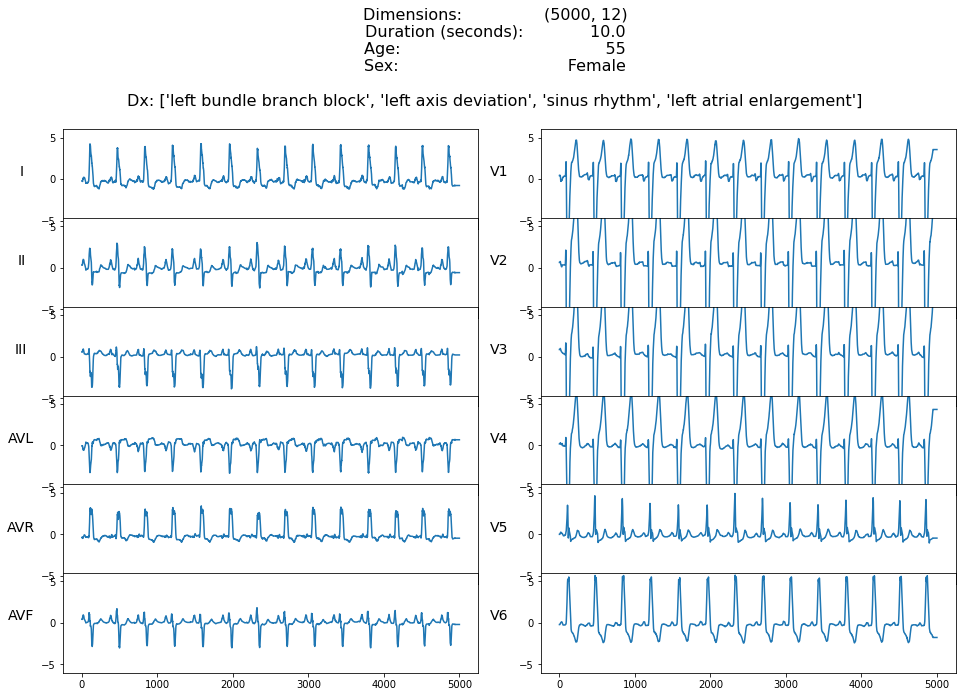

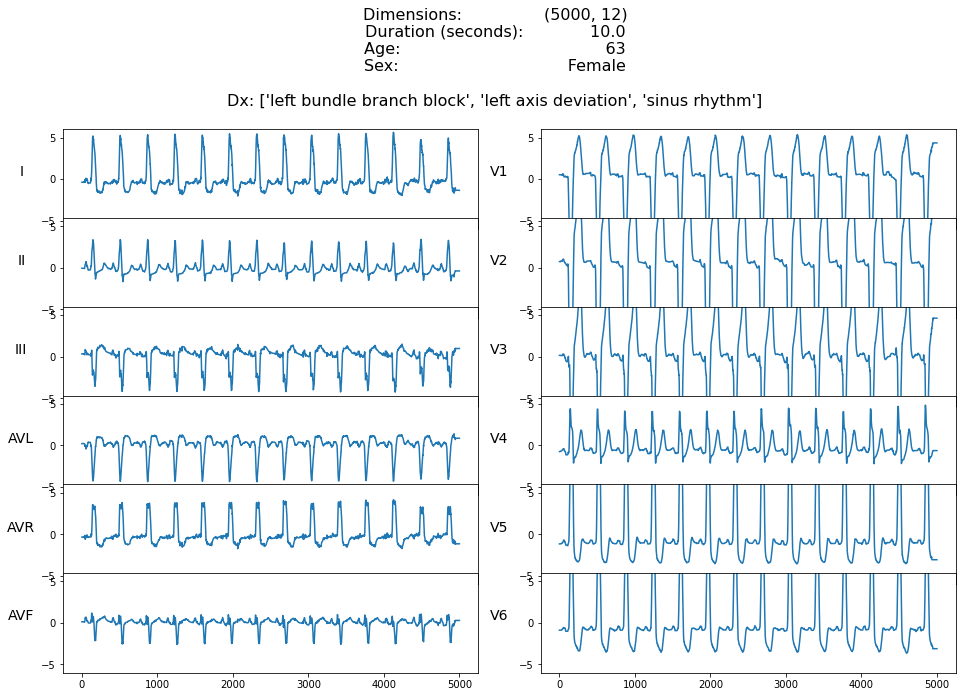

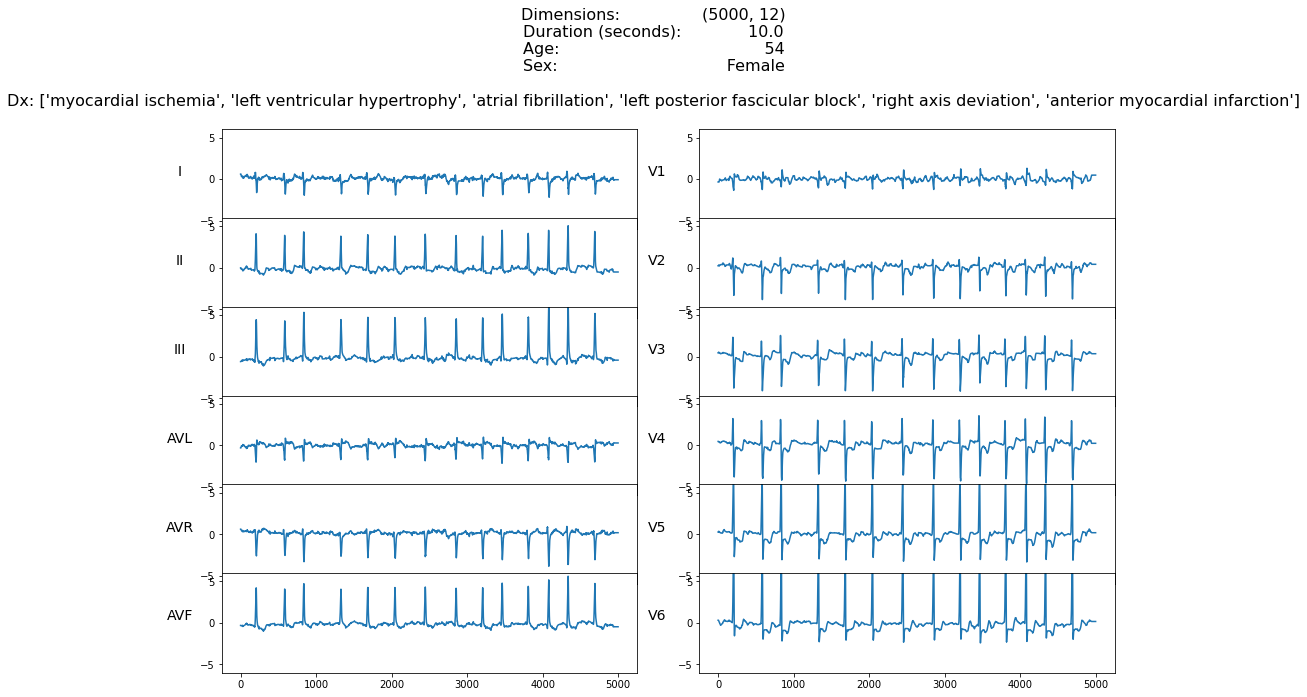

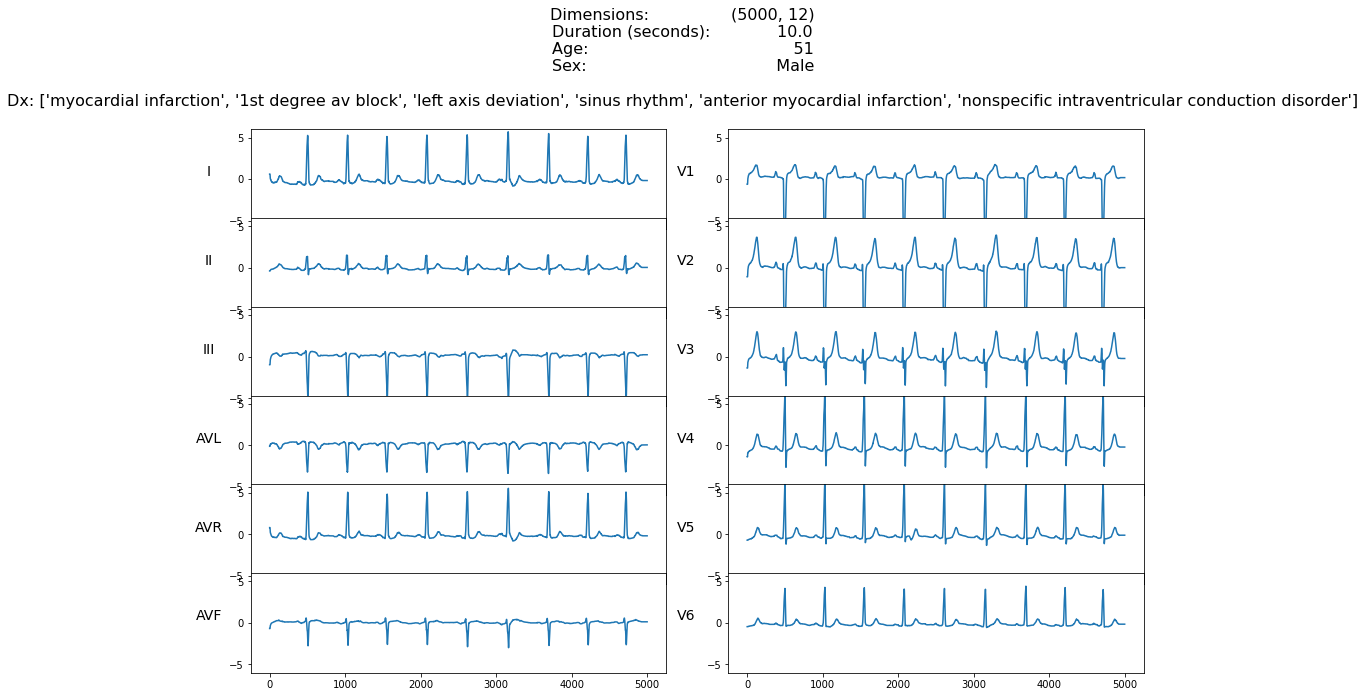

In [25]:
# For each of the codes, select n_sample random examples and plot them.
# Note that there can be intersections and thus repetition of examples.

for code in list(urgency.index)[:2]:    
    
    Y_code = md.sample_Y_by_code(Y_df, code, n_sample=2, random_state=203129)    
    pa.plot_various_given_code(Y_code, code, requirements, n_sample=2, verbose=True, show=True)

We plot some more without showing them and store them.

In [26]:
# for code in urgency.index:    
    
#     Y_code = md.sample_Y_by_code(Y_df, code, n_sample=n_sample, random_state=203129)    
#     pa.plot_various_given_code(Y_code, code, requirements, n_sample=n_sample, verbose=False, show=False)

#### Urgency level 2

We basically repeat everything with Urgency level 2, 3 and 4.

In [27]:
urgency = md.dx_by_urgency(urgency_level=2, requirements=requirements)
urgency

,Diagnostic Description,Abbreviation,PTB-XL,Total,Kind
SNOMED CT Code,,,,,
164917005,qwave abnormal,QAb,548,1013,most
164934002,t wave abnormal,TAb,2345,4673,most
59931005,t wave inversion,TInv,294,1112,most
426434006,anterior ischemia,AnMIs,44,325,less
425419005,inferior ischaemia,IIs,219,670,less
425623009,lateral ischaemia,LIs,142,1045,less
164861001,myocardial ischemia,MIs,2175,2559,less
429622005,st depression,STD,1009,1977,less


In [28]:
# for code in urgency.index:    
    
#     Y_code = md.sample_Y_by_code(Y_df, code, n_sample=n_sample, random_state=203129)    
#     pa.plot_various_given_code(Y_code, code, requirements, n_sample=n_sample, verbose=False, show=False)

#### Urgency level 3

In [29]:
urgency = md.dx_by_urgency(urgency_level=3, requirements=requirements)
urgency

,Diagnostic Description,Abbreviation,PTB-XL,Total,Kind
SNOMED CT Code,,,,,
713427006,complete right bundle branch block,CRBBB,542,683,most
713426002,incomplete right bundle branch block,IRBBB,1118,1611,most
445118002,left anterior fascicular block,LAnFB,1626,1806,most
698252002,nonspecific intraventricular conduction disorder,NSIVCB,789,997,most
164951009,abnormal QRS,abQRS,3389,3389,less
251120003,incomplete left bundle branch block,ILBBB,77,205,less
445211001,left posterior fascicular block,LPFB,177,202,less
164873001,left ventricular hypertrophy,LVH,2359,3759,less
428750005,nonspecific st t abnormality,NSSTTA,381,3554,less


In [30]:
# for code in urgency.index:    
    
#     Y_code = md.sample_Y_by_code(Y_df, code, n_sample=n_sample, random_state=203129)    
#     pa.plot_various_given_code(Y_code, code, requirements, n_sample=n_sample, verbose=False, show=False)

#### Urgency level 4

In [31]:
urgency = md.dx_by_urgency(urgency_level=4, requirements=requirements)
urgency

,Diagnostic Description,Abbreviation,PTB-XL,Total,Kind
SNOMED CT Code,,,,,
270492004,1st degree av block,IAVB,797,2394,most
164889003,atrial fibrillation,AF,1514,3475,most
164890007,atrial flutter,AFL,73,314,most
39732003,left axis deviation,LAD,5146,6086,most
251146004,low qrs voltages,LQRSV,182,556,most
10370003,pacing rhythm,PR,296,299,most
284470004,premature atrial contraction,PAC,398,1729,most
164947007,prolonged pr interval,LPR,340,340,most
111975006,prolonged qt interval,LQT,118,1513,most


In [32]:
# for code in urgency.index:    
    
#     Y_code = md.sample_Y_by_code(Y_df, code, n_sample=n_sample, random_state=203129)    
#     pa.plot_various_given_code(Y_code, code, requirements, n_sample=n_sample, verbose=False, show=False)

### Adding urgency to Y + EDA on DX

There are certain approaches we can take to classify the diagnoses:

    1. Have a multi-binary classification model that checks whether there is precense of the dx.
    2. Have a multi-class classification model that checks the urgency of opoeration for the patient.
    
Note how in a way the former one includes the latter, since having a strong indication of a dx that belongs 
to a certain urgency level would implicitly determine it.

In the latter one, we still have to determine how the combination of urgencies in each patient can change the overall
urgency. For example, suppose a patient has 3 dx with urgency level 2, and 3 with urgency level 3. Would this patient
be classified as an urgency level 2 one because the maximum urgency level is 2, or should it be ascended to 1 since it has multiple dx.

For the moment, we will assume the maximum per dx urgency level as the overall patient's one.

In [33]:
# Get OHE on the urgency of the diagnosis
Y_urgencies = np.array(pd.get_dummies(labels['Urgency']))

# Multiply by the dx in each row to get the total amount of dx per urgency
Y_urgencies = np.array(Y_df.iloc[:, 11:]) @ Y_urgencies

print(Y_urgencies.shape)
Y_urgencies

(21837, 4)


array([[0, 0, 0, 2],
       [0, 0, 0, 2],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 0, 1]], dtype=int64)

The maximum number of dx per patient in PTB-XL is 10


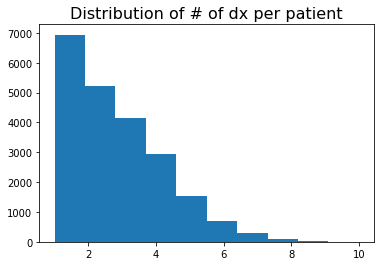

In [34]:
fig, ax = plt.subplots()
ax.hist(Y_urgencies.sum(1))
ax.set_title('Distribution of # of dx per patient', fontsize=16)
print("The maximum number of dx per patient in {} is {}".format(current_db, Y_urgencies.sum(1).max()))

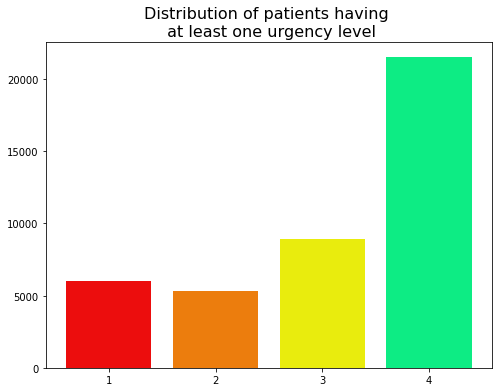

In [35]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(['1','2','3','4'], (Y_urgencies > 0).sum(0), color=list(urgency_colors.values()))
ax.set_title('Distribution of patients having \n at least one urgency level', fontsize=16);

As mentioned, the patient's urgency level will be the highest priority urgency level per dx. Thus,
we multiply each of the previous matrix columns (urgencies) by wieghts, so that the maximum per row reflects the maximum urgency.

In [36]:
Y_urgencies_max = Y_urgencies.copy()

Y_urgencies_max[:, 0] = Y_urgencies_max[:, 0] * 1000000
Y_urgencies_max[:, 1] = Y_urgencies_max[:, 1] * 10000
Y_urgencies_max[:, 3] = Y_urgencies_max[:, 3] * 100

Y_urgencies_max = Y_urgencies_max.argmax(1) + 1

Y_urgencies_max

array([4, 4, 4, ..., 2, 4, 4], dtype=int64)

We note that given the maximum value approach, there are too few observations in the urgency level 3, leaving it practically unusable.

Urgency level 3 has 77 registers.


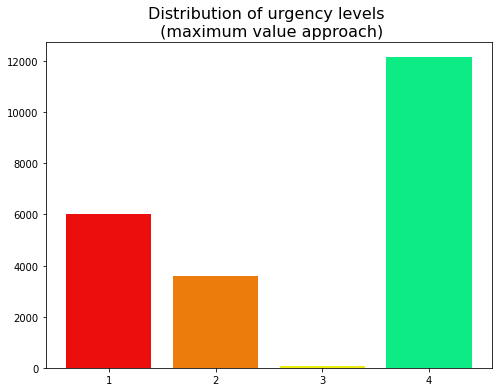

In [37]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(['1','2','3','4'], np.histogram(Y_urgencies_max, bins=4)[0], color=list(urgency_colors.values()))
ax.set_title('Distribution of urgency levels \n (maximum value approach)', fontsize=16);
print("Urgency level 3 has", np.histogram(Y_urgencies_max, bins=4)[0][2], "registers.")

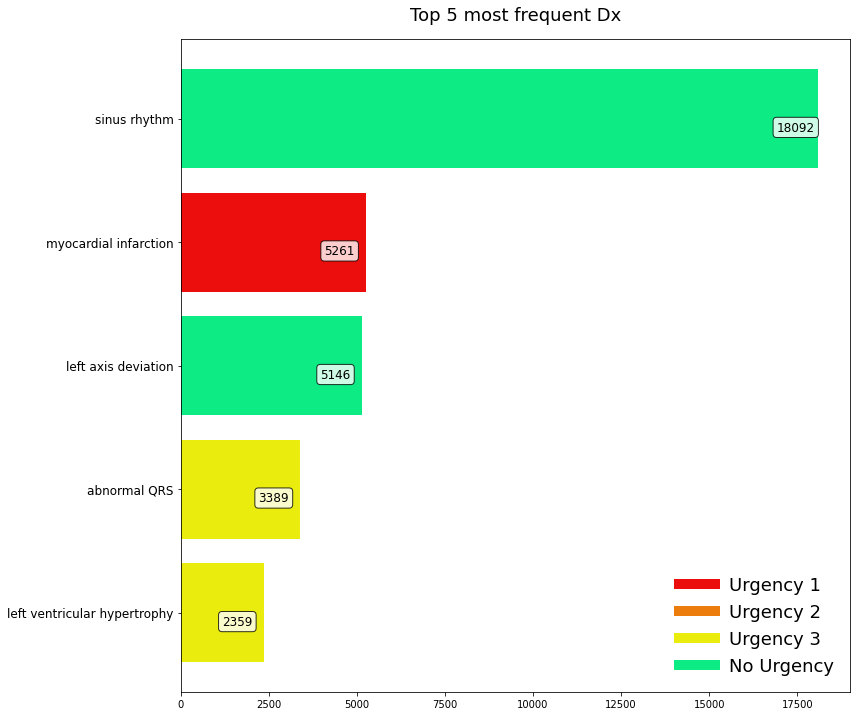

In [38]:
pa.top_n_dx_plot(n=5, Y_df=Y_df.iloc[:,11:], requirements=requirements)

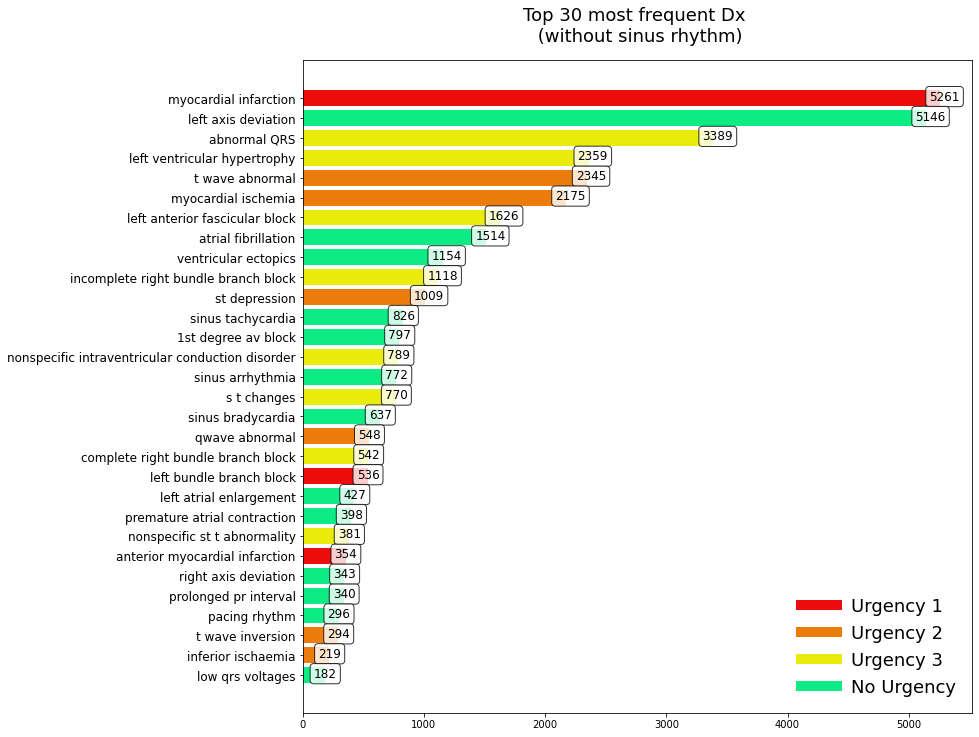

In [39]:
pa.top_n_dx_plot(n=30,Y_df=Y_df.iloc[:,11:], requirements=requirements, m=1, 
                 title="Top 30 most frequent Dx \n (without sinus rhythm)")

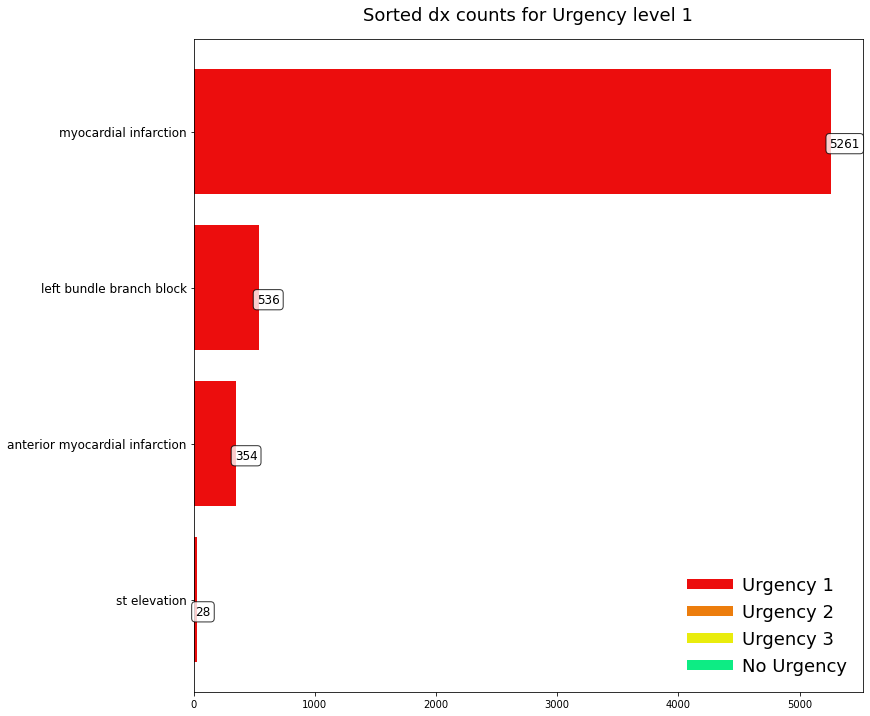

In [40]:
urgency = md.dx_by_urgency(1, requirements)
pa.top_n_dx_plot(n=5,Y_df=Y_df[urgency.index], requirements=requirements,
                title="Sorted dx counts for Urgency level 1")

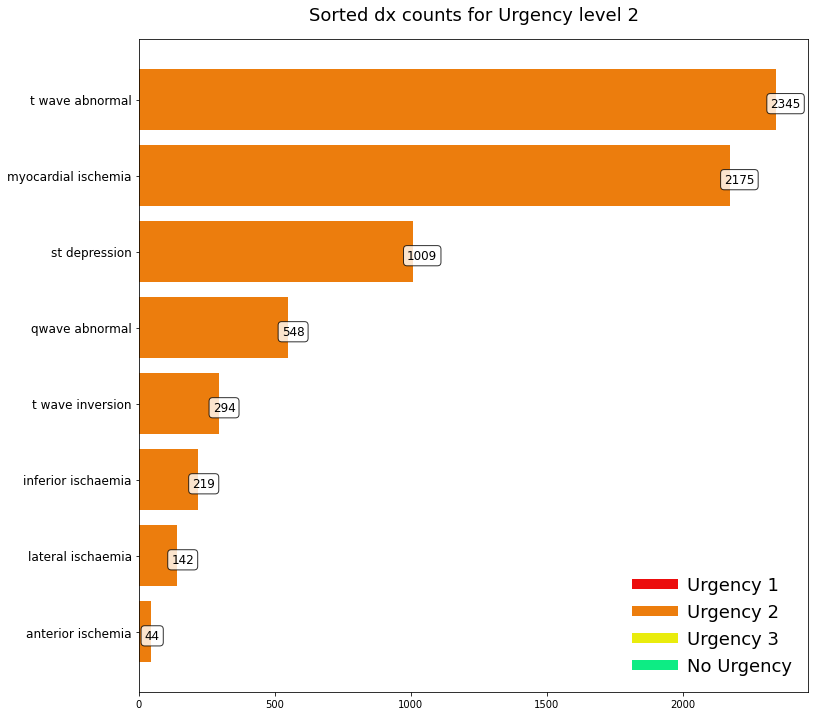

In [41]:
urgency = md.dx_by_urgency(2, requirements)
pa.top_n_dx_plot(n=10,Y_df=Y_df[urgency.index], requirements=requirements,
                title="Sorted dx counts for Urgency level 2")

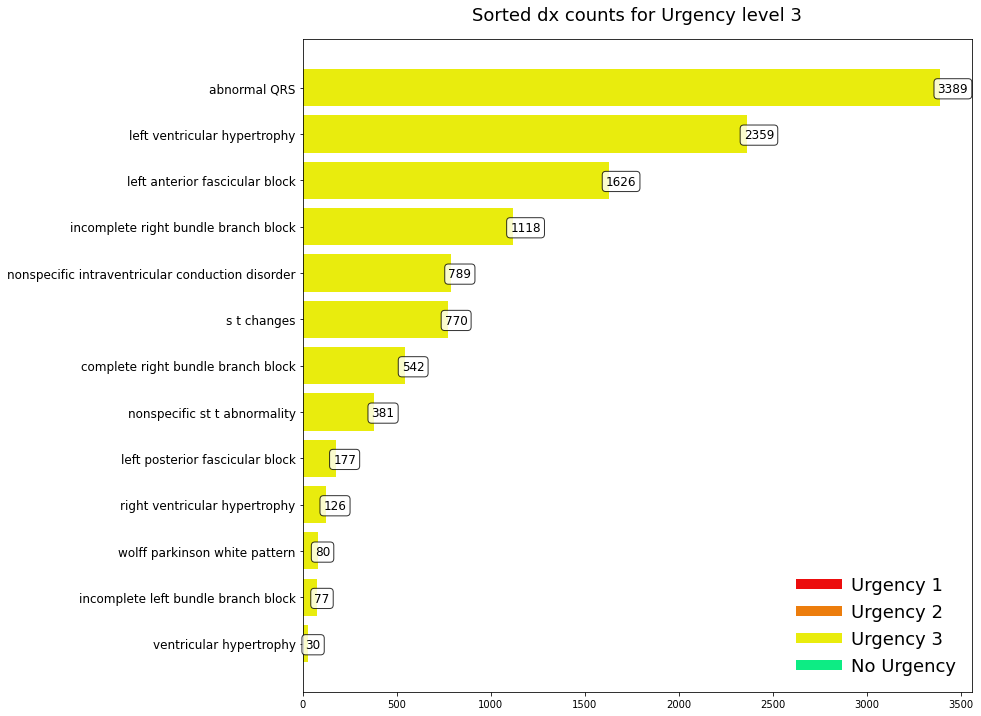

In [42]:
urgency = md.dx_by_urgency(3, requirements)
pa.top_n_dx_plot(n=15,Y_df=Y_df[urgency.index], requirements=requirements,
                title="Sorted dx counts for Urgency level 3")

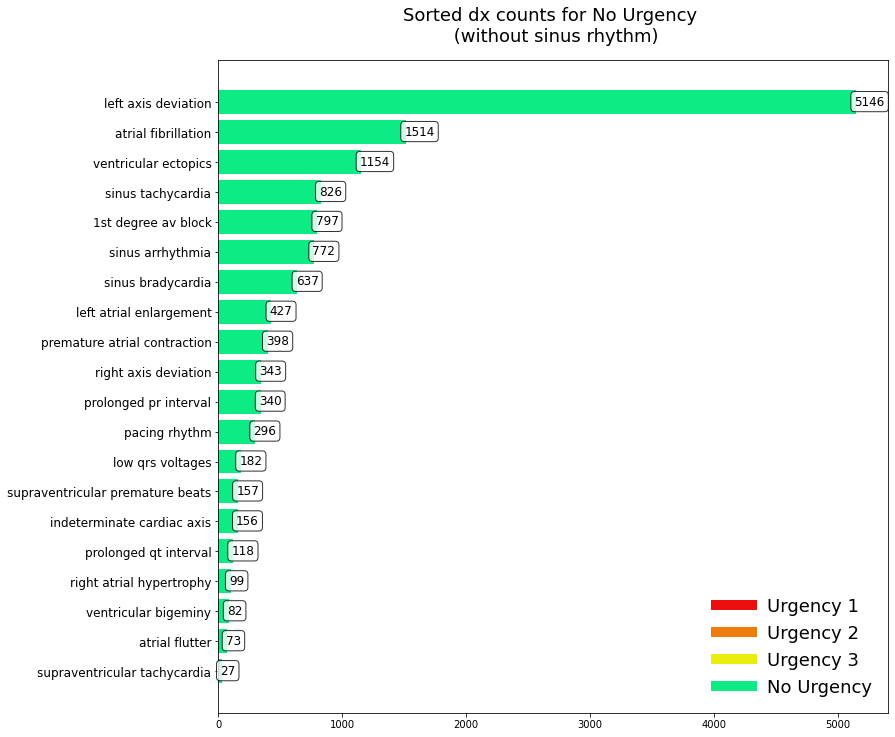

In [43]:
urgency = md.dx_by_urgency(4, requirements)
pa.top_n_dx_plot(n=20,Y_df=Y_df[urgency.index], requirements=requirements, m=1,
                title="Sorted dx counts for No Urgency \n (without sinus rhythm)")

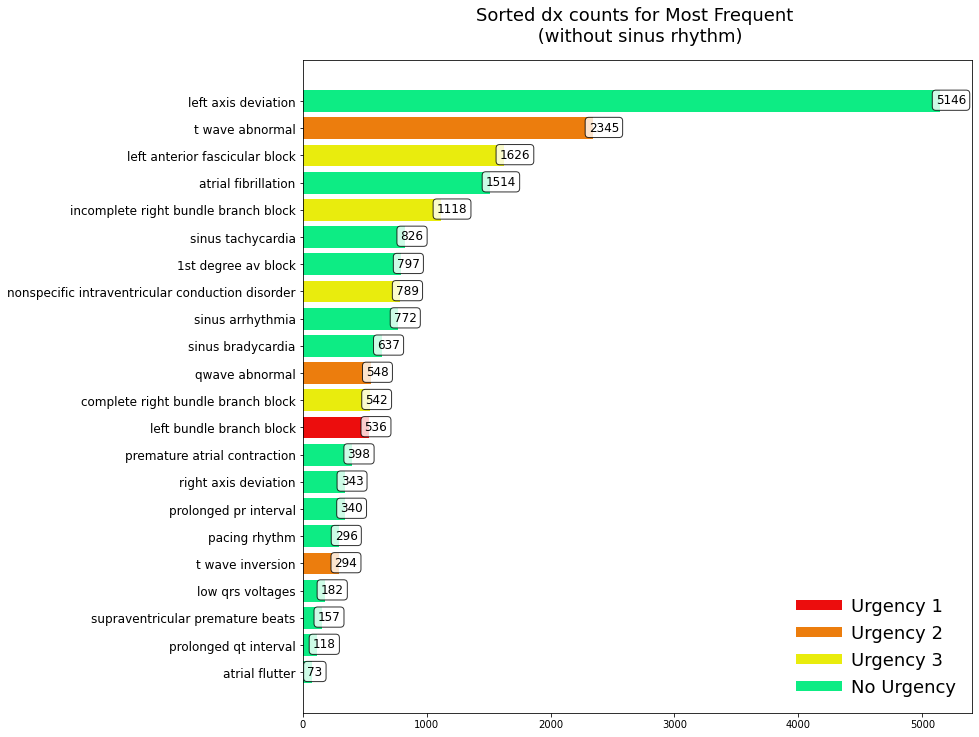

In [44]:
kind = md.dx_by_kind('most', requirements)
pa.top_n_dx_plot(n=30,Y_df=Y_df[kind.index], requirements=requirements, m=1,
                 title="Sorted dx counts for Most Frequent \n (without sinus rhythm)")

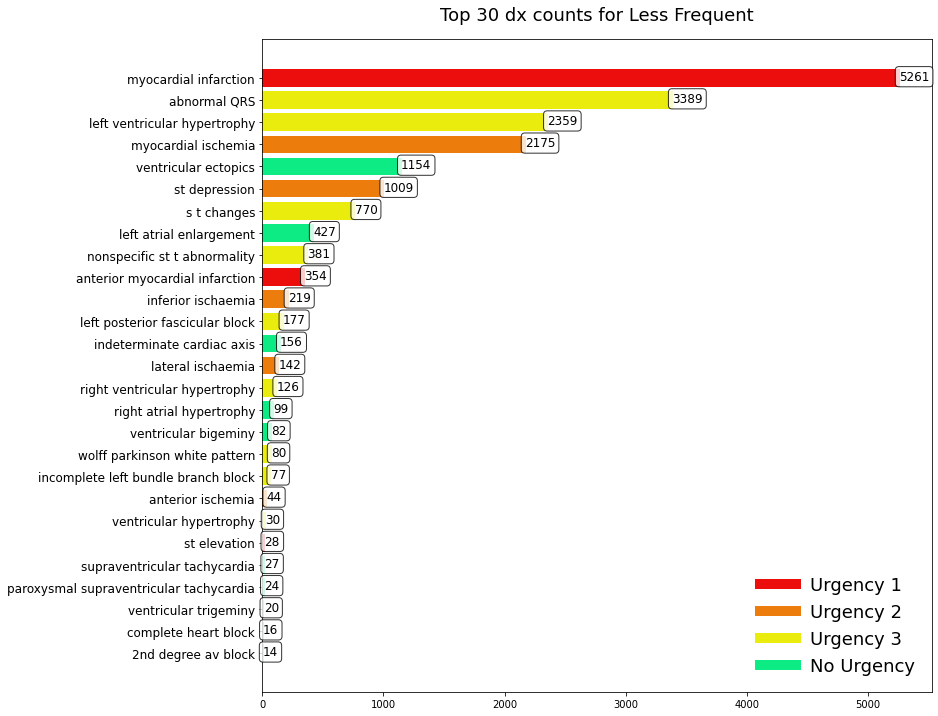

In [45]:
kind = md.dx_by_kind('less', requirements)
pa.top_n_dx_plot(n=30,Y_df=Y_df[kind.index], requirements=requirements,
                 title="Top 30 dx counts for Less Frequent")

### Check Signals from different sources

This section was earlier used to compare from different sources. Since we have already done the analysis, they need not be run. Even they might not work given the pathing changes.

The most valuable lesson from this section was to understand the **mV** in the registers. It is a measure on the height of the signals. We need to eventualy convert all to have the same mV to make them comparable.

File 1
 [[-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 [-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 [-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 ...
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]]

File 2
 [[-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 ...
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]]

File 1

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  56
Patient's sex:  Female
Patient's diagnosis:  ['low qrs voltages', 'sinus rhythm']

File 2

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  56
Patient's sex:  Female
Patient's diagnosis:  ['low qrs voltages', 'sinus rhythm']


We can see that the c

C:\Users\Mike\Documents\maestria-itam\estancia-investigacion\proyecto-ecg\pruebas\scripts\plots_aux.py:242: RuntimeWarning: invalid value encountered in true_divide
  print('\nWe can see that the constant is 0.2 (or 5, depending on the order): (Unique values of the divisions)',


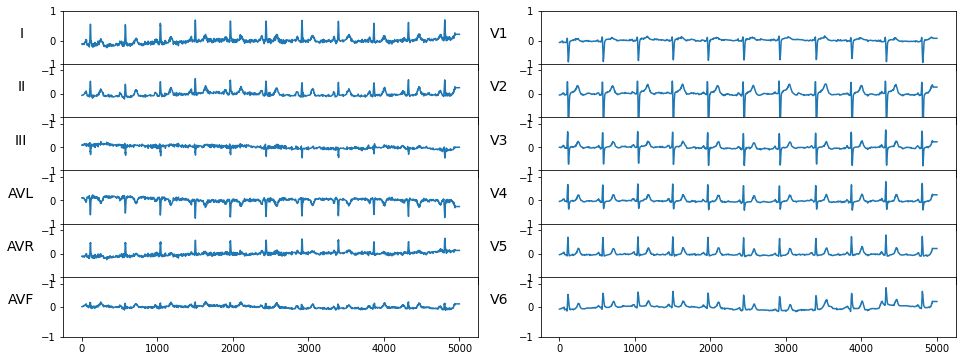

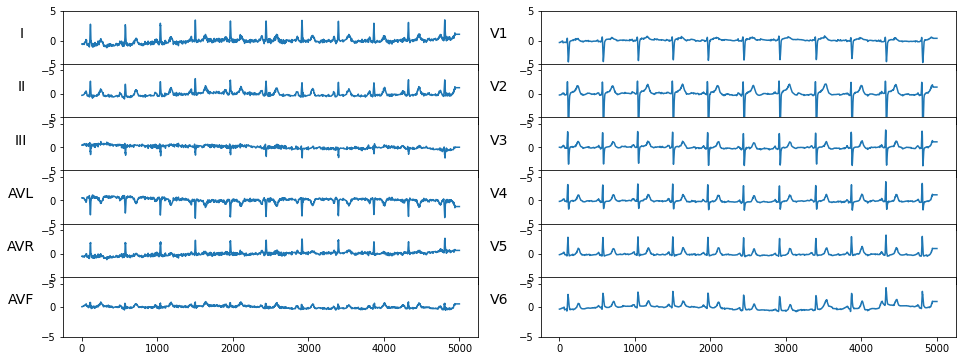

In [102]:
# # Choose a file
# filename = 'HR00001'

# # Compare Physionet (https://physionet.org/content/challenge-2020/1.0.2/)
# #      vs Kaggle (https://www.kaggle.com/code/bjoernjostein/physionet-challenge-2020/data?select=WFDB)
# pa.compare_2_ecgs(filename_1 = f'../data/{filename}', filename_2 = path+filename, 
#                   requirements = requirements, ylim_1 = (-1,1))

File 1
 [[-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 [-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 [-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 ...
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]]

File 2
 [[-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 [-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 [-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 ...
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]]

File 1

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  62
Patient's sex:  Male
Patient's diagnosis:  ['myocardial infarction', 'abnormal QRS', 'left axis deviation', 'sinus rhythm', 'left atrial enlargement', 'nonspecific intraventricular conduction disorder']

File 2

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Pat

C:\Users\Mike\Documents\maestria-itam\estancia-investigacion\proyecto-ecg\pruebas\scripts\plots_aux.py:242: RuntimeWarning: invalid value encountered in true_divide
  print('\nWe can see that the constant is 0.2 (or 5, depending on the order): (Unique values of the divisions)',


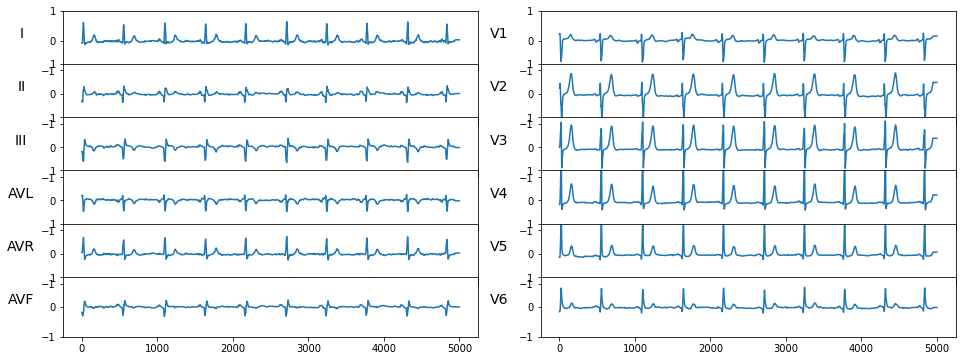

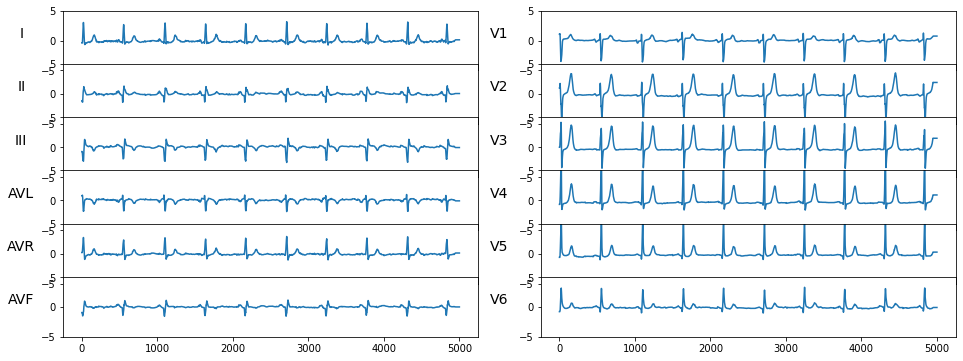

In [103]:
# # Choose a file
# filename = 'HR18052'

# # Compare Physionet (https://physionet.org/content/challenge-2020/1.0.2/)
# #      vs Kaggle (https://www.kaggle.com/code/bjoernjostein/physionet-challenge-2020/data?select=WFDB)
# pa.compare_2_ecgs(filename_1 = f'../data/{filename}', filename_2 = path+filename, 
#                   requirements = requirements, ylim_1 = (-1,1))

File 1
 [[-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 [-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 [-0.115 -0.05   0.065 ... -0.035 -0.035 -0.075]
 ...
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]
 [ 0.21   0.205 -0.005 ...  0.185  0.17   0.18 ]]

File 2
 [[-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 ...
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]]

File 1

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  No Age
Patient's sex:  No Sex
Patient's diagnosis:  No Diagnoses

File 2

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  56
Patient's sex:  Female
Patient's diagnosis:  ['low qrs voltages', 'sinus rhythm']


We can see that the constant is 0.2 (or 5

C:\Users\Mike\Documents\maestria-itam\estancia-investigacion\proyecto-ecg\pruebas\scripts\plots_aux.py:266: RuntimeWarning: invalid value encountered in true_divide


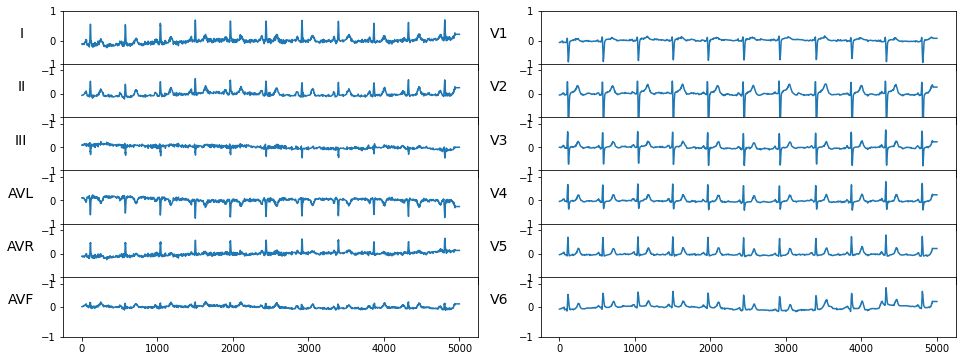

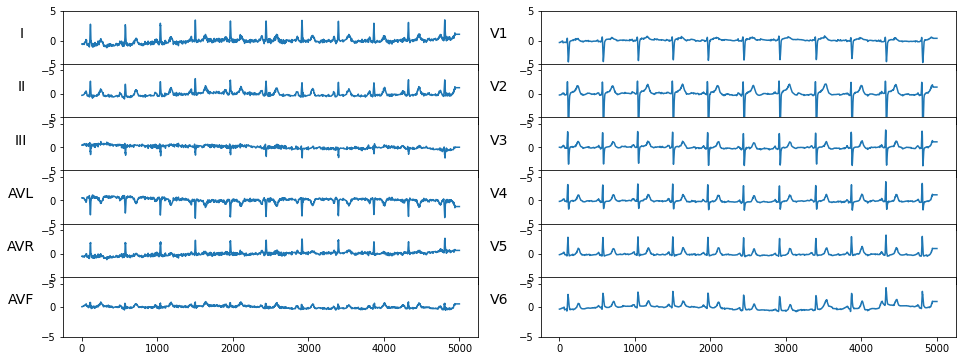

In [106]:
# # Choose a file
# filename_ptbxl = '00001_hr'
# filename = 'HR00001'

# # Compare PTB-XL Original (https://physionet.org/content/ptb-xl/1.0.0/)
# #      vs Kaggle (https://www.kaggle.com/code/bjoernjostein/physionet-challenge-2020/data?select=WFDB)
# pa.compare_2_ecgs(filename_1 = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/' + \
#                   f'records500/00000/{filename_ptbxl}', filename_2 = path+filename, 
#                   requirements = requirements, ylim_1 = (-1,1))

File 1
 [[-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 [-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 [-0.08  -0.23  -0.15  ... -0.135 -0.125 -0.16 ]
 ...
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]
 [ 0.025  0.01  -0.015 ...  0.18   0.05  -0.02 ]]

File 2
 [[-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 [-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 [-0.4   -1.15  -0.75  ... -0.675 -0.625 -0.8  ]
 ...
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]
 [ 0.125  0.05  -0.075 ...  0.9    0.25  -0.1  ]]

File 1

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  No Age
Patient's sex:  No Sex
Patient's diagnosis:  No Diagnoses

File 2

The dimensions of this ECG are:  (5000, 12)
Duration (seconds):  10.0
Patient's age:  62
Patient's sex:  Male
Patient's diagnosis:  ['myocardial infarction', 'abnormal QRS', 'left axis deviation', 'sinus rhythm', '

C:\Users\Mike\Documents\maestria-itam\estancia-investigacion\proyecto-ecg\pruebas\scripts\plots_aux.py:266: RuntimeWarning: invalid value encountered in true_divide
  frac = example_1[0]/example_2[0]


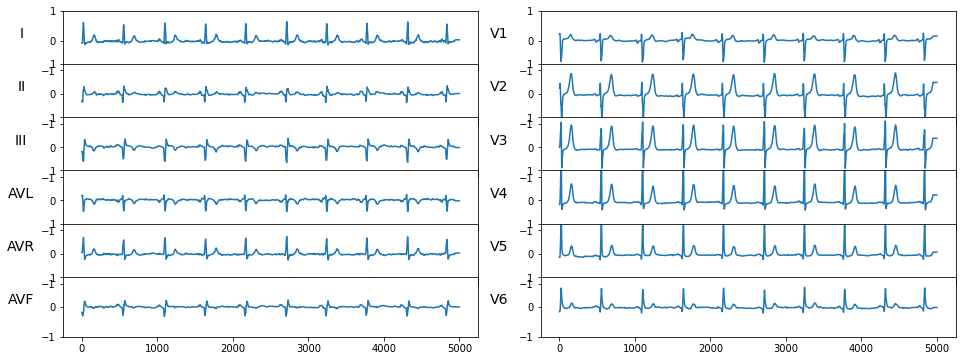

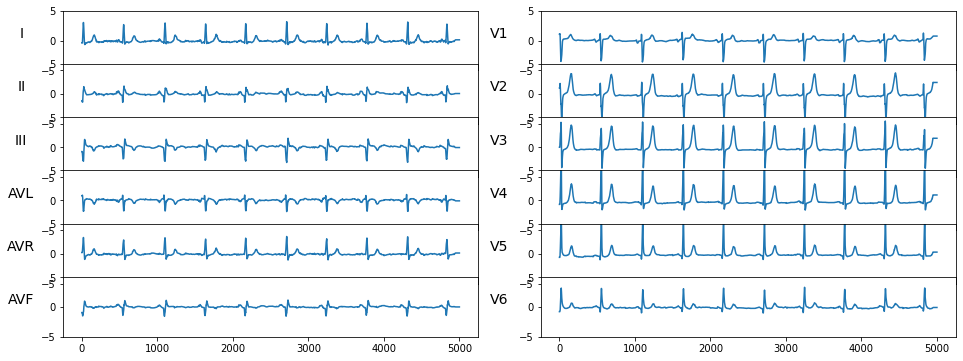

In [110]:
# # Choose a file
# filename_ptbxl = '18052_hr'
# filename = 'HR18052'

# # Compare PTB-XL Original (https://physionet.org/content/ptb-xl/1.0.0/)
# #      vs Kaggle (https://www.kaggle.com/code/bjoernjostein/physionet-challenge-2020/data?select=WFDB)
# pa.compare_2_ecgs(filename_1 = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/' + \
#                   f'records500/18000/{filename_ptbxl}', filename_2 = path+filename, 
#                   requirements = requirements, ylim_1 = (-1,1))

For a sanity check, we want to see how small is the sum of the squared differences between the files we first had (PTB-XL) and the ones downloaded from Kaggle once applied the scaling factor. We do this just for the first 100 values.

In [127]:
# X_PTB = []

# for i in range(99):
#     if i < 9:
#         X_PTB.append(wfdb.rdsamp('../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/' + \
#                               f'records500/00000/0000{i+1}_hr')[0])
#     else:
#         X_PTB.append(wfdb.rdsamp('../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/' + \
#                               f'records500/00000/000{i+1}_hr')[0])

# # The sum of the squared differences is virtually 0        
# diff = X_PTB - X[:99]*0.2
# print('The difference is practically 0:', (diff**2).sum())

The difference is practically 0: 4.085840097520608e-10
